# Exploration of physics-informed regression modelling for digital twins

## Table of Contents
* [Introduction](#Introduction)
    * [Motivation and Background](#Motivation-and-Background)
    * [A core system architecture for a physics-informed digital twin](#A-core-system-architecture-for-a-physics-informed-digital-twin)
* [Modelling an example physical system](#Modelling-an-example-physical-system)
    * [Initial analysis of artificial measurement data](#Initial-analysis-of-artificial-measurement-data)
    * [Fitting an unconstrained linear regression model](#Fitting-an-unconstrained-linear-regression-model)
    * [A naive approach to constrained linear regression modelling](#A-naive-approach-to-constrained-linear-regression-modelling)
* [A physics-informed approach to linear regression modelling](#A-physics-informed-approach-to-linear-regression-modelling)
    * [Defining a cost function for least squares linear regression](#Defining-a-cost-function-for-least-squares-linear-regression)
    * [A direct solution for least squares regression using linear algebra](#A-direct-solution-for-least-squares-regression-using-linear-algebra)
    * [Regularised linear regression and custom loss functions](#Regularised-linear-regression-and-custom-loss-functions)
* [Regularised linear regression modelling of our example spring measurement system](#Regularised-linear-regression-modelling-of-our-example-spring-measurement-system)
    * [Regularisation of model intercept parameter in regression model](#Regularisation-of-model-intercept-parameter-in-regression-model)
    * [Application of regularised intercept parameter regression model](#Application-of-regularised-intercept-parameter-regression-model)
    * [Regularisation of both the model intercept and slope parameters](#Regularisation-of-both-the-model-intercept-and-slope-parameters)
* [Conclusion](#Conclusion)

## Introduction

This document contains a basic exploration of possible approaches for developing predictive digital twins which use real sensor measurement data to calibrate physics-based models.

Simple examples based on a hypothetical spring displacement measurement system are discussed.

### Motivation and Background

Hybrid AI modelling techniques are an active area of research and are considered a potential basis for advanced digital twin systems. There is particular interest in the applications of digital twins for prognostics and health management (PHM) of industrial machinery and systems. 

Many background resources in this area are available. For example, this presentation [Predictive Digital Twins: From physics-based modeling to scientific machine learning (YouTube)](https://youtu.be/ZuSx0pYAZ_I) describes some of the technical challenges faced in developing useful predictive digital twin systems (with an example application in the structural health monitoring-based control optimisation for UAVs).

This paper contains a good discussion of the challenges and potential future developments in deep learning for applications in prognostics and health management: [Potential, challenges and future directions for deep learning in prognostics
and health management applications](https://arxiv.org/abs/2005.02144).

The following publications provide a more comprehensive review of the current state-of-the-art for digital twin modelling approaches: [Part 1: Modeling and Twinning Enabling Technologies](https://arxiv.org/abs/2208.14197) and [Part 2: Roles of Uncertainty Quantification and Optimization](https://arxiv.org/abs/2208.12904).

These resources provide fascinating insights into potential future developments in this area, however they typically focus on advanced methodologies applied to relatively complex use cases (as might be expected within cutting-edge research). In this document we take inspiration from these works and aim to explore more accessible approaches applied to much simpler scenarios.

### A core system architecture for a physics-informed digital twin

A high level overview of a possible core system architecture for a physics-informed digital twin is shown in Figure 1 (ref: [Fusing physics-based and deep learning models for prognostics](https://www.sciencedirect.com/science/article/pii/S0951832021004725)).

<img src="Figures/Example Digital Twin System Core Architecture.JPG" width="600" style="display: block; margin-left:auto; margin-right:auto"/>
<p style="text-align: center; font-size:14px; font-family:serif">
    Figure 1: An example core system architecture for a physics-informed digital twin
</p>

Within this digital twin architecture, the predictive model (shown as a deep neural network, but could be any predictive model) takes information from both the physics-based model and real sensor measurement data. Additionally, the sensor data is over time used to calibrate the physics-based model - information from this calibration process also feeds into the predictive model. 

In this scheme we recognise that any physics-based model will have limitations in its ability to fully represent the real (physical) system. The calibration process is therefore introduced as a mechanism by which any model inaccuracies can, in theory, be identified and ultimately corrected for. This calibrated physics-based model in turn can be used to guide the predictive model in its assessment of the system state and behaviour based on sensor readings and other inputs.

## Modelling an example physical system

We can consider the example spring force-displacement measurement system in Figure 2 below. In this case, we have a forge gauge measuring the spring force (F), the displacement of the spring measured at the free end (x), and the spring constant (k). In the elastic deformation region, these parameters are related by Hooke's law:

$$F = -k x \tag{1}$$

This is our base physical model of the system. We are aware from the offset that this model is imperfect and a simplification of reality. There are unknown physical factors which may impact the behaviour - for example, variations in the temperature of the spring could impact the spring constant (at least to a small degree). However, this is a simple enough model to start off with and enables us to describe the methodology in relation to a real system.

<img src="Figures/Example Spring System (diagrams.net).drawio.png" width="500" style="display: block; margin:auto"/>
<p style="text-align: center; font-size:14px; font-family:serif">
    Figure 2: An example spring force-displacement measurement system
</p>

### Initial analysis of artificial measurement data

To explore this modelling approach we can first generate some synthetic data, starting very simple with 5 measurement sampling points taken in 10 cm displacement intervals from -20 cm to 20 cm. 

We'll also specify a nominal spring coefficient of 100 N/m, and use our physics model to generate the synthetic force measurements. We'll then add a small amount of random noise to the data to make it slightly more realistic. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

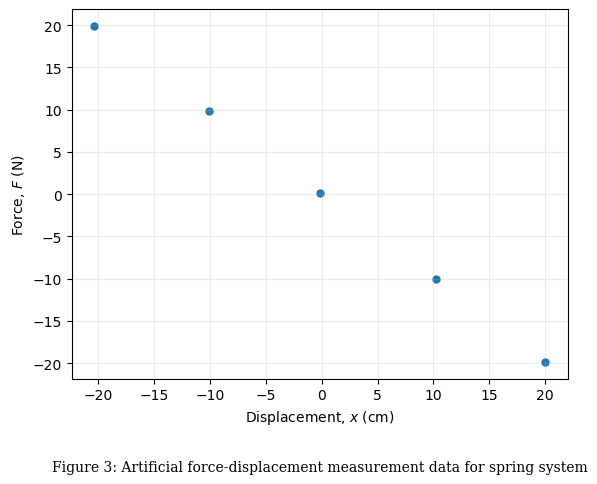

In [2]:
# Create sample data
k = 100 # N/m
x_data = np.arange(-20, 30, 10)  # in cm
F_data = -1 * k * (x_data*0.01) # first convert x values to m
data = pd.DataFrame([x_data, F_data], index=['x', 'F']).T

# add very small random Gaussian measurement noise
data['x'] = data['x'].add(np.random.normal(size=x_data.size)*(x_data.ptp()/250))
data['F'] = data['F'].add(np.random.normal(size=F_data.size)*(F_data.ptp()/250))

# Plot figure
ax = data.plot.scatter(x='x', y='F', s=25)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
plt.grid(alpha=0.25)

caption = "Figure 3: Artificial force-displacement measurement data for spring system"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

### Fitting an unconstrained linear regression model

Since our physics-based model of the system is a linear model, we can first attempt to fit a naive linear regression model to the data.

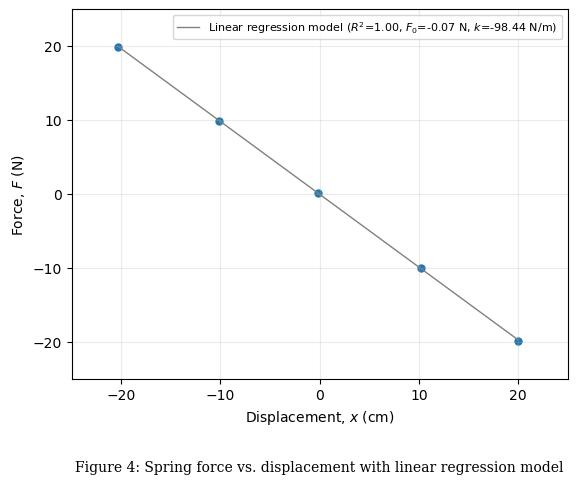

In [3]:
# fit linear regression model
regressor = LinearRegression()
regressor.fit(data['x'].to_frame().values, data['F'].values)

# now, we use the model to predict the force at the displacement measurement points
data_model = data.copy(deep=True)
data_model['F'] = regressor.predict(data_model['x'].to_frame().values)

# Plot measurement data
ax = data.plot.scatter(x='x', y='F', s=25)

# plot regression model line (with helper function)
def plot_and_format_regression_line(regressor, x, y, ax):
    reg_score =  "%.2f" % regressor.score(x, y)
    reg_int = "%.2f" % regressor.intercept_
    reg_slope = "%.2f" % (100*regressor.coef_[0]) # convert to N/m
    model_label = f'Linear regression model ($R^2$={reg_score}, $F_0$={reg_int} N, $k$={reg_slope} N/m)'
    data_model.plot.line(x='x', y='F', ax=ax, lw=1, label=model_label, color='grey')
    return

plot_and_format_regression_line(regressor, data['x'].to_frame().values, data['F'].values, ax)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.legend(fontsize=8)
plt.grid(alpha=0.25)

caption = "Figure 4: Spring force vs. displacement with linear regression model"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

Here we can see that the model fits the data well - it produces a slope (i.e. spring constant) very close to the nominal value used to generate the data (100 N/m), and the intercept is close to 0 (as is also predicted by the physics-based model).

However, what happens to the regression model fit if one of our data points contains a significant measurement error?

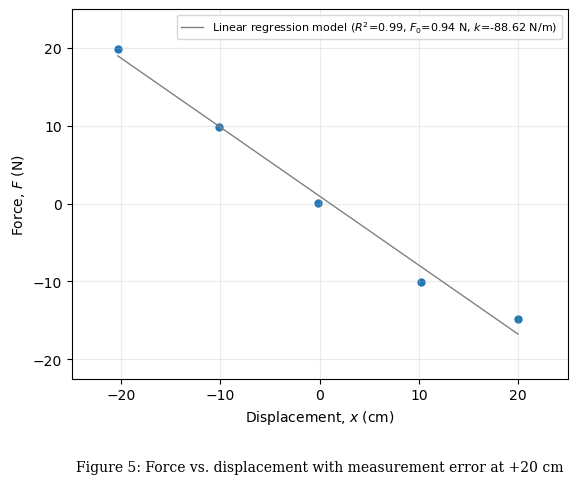

In [4]:
# introduce force measurement error (i.e. offset) onto 5th data point
data_error = data.copy(deep=True)
data_error.loc[4, 'F'] += 5

# fit linear regression model
regressor = LinearRegression()
regressor.fit(data_error['x'].to_frame().values, data_error['F'].values)

# now, we use the model to predict the force at the displacement measurement points
data_model = data_error.copy(deep=True)
data_model['F'] = regressor.predict(data_model['x'].to_frame().values)

# Plot measurement data
ax = data_error.plot.scatter(x='x', y='F', s=25)

# plot regression model line
plot_and_format_regression_line(regressor, data_error['x'].to_frame().values, data_error['F'].values, ax)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-22.5, 25)
ax.legend(fontsize=8)
plt.grid(alpha=0.25)

caption = "Figure 5: Force vs. displacement with measurement error at +20 cm"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

Here we see the model is significantly affected by the measurement outlier. Even though the $R^2$ value is close to 1, the average error in the model residuals (difference between measured and predicted) is much greater than the random Gaussian noise that we added to the data - the model is systematically biased due to the presence of the outlier, and the bias is itself a function of the displacement position. The model slope, $-k$, is also much different to the nominal spring constant of 100 N/m, so the model is not representing the actual physical system very well.  

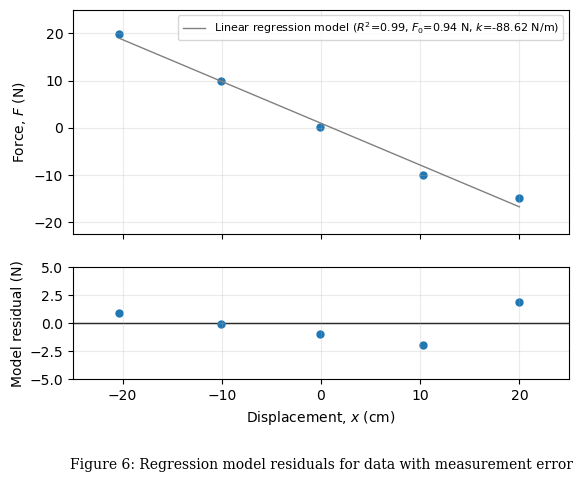

In [5]:
# Create figure and add Gridspec subplot array
fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=(2,1))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# Plot measurement data in top chart
data_error.plot.scatter(x='x', y='F', ax=ax0, s=25)

# plot regression model line
plot_and_format_regression_line(regressor, data_error['x'].to_frame().values, data_error['F'].values, ax0)

ax0.set_ylabel('Force, $F$ (N)')
ax0.set_xlim(-25, 25)
ax0.set_ylim(-22.5, 25)
ax0.legend(fontsize=8)
ax0.grid(alpha=0.25)

# Calculate and plot residuals (actual - predicted) in bottom chart
data_res = data_error.copy(deep=True)
data_res['F'] = data_error['F'].subtract(data_model['F'])

data_res.plot.scatter(x='x', y='F', ax=ax1, s=25)

ax1.set_xlabel('Displacement, $x$ (cm)')
ax1.set_ylabel('Model residual (N)')
ax1.set_ylim(-5, 5)
ax1.grid(alpha=0.25)
ax1.axhline(0, color='k', lw=1, zorder=-1)

caption = "Figure 6: Regression model residuals for data with measurement error"
plt.text(.5, -.8, caption, ha='center', font='serif', fontweight='medium', transform=ax1.transAxes)
plt.show()


Plotting the model residuals, we can see that the model produces roughly similar residuals for the 4th and 5th data points (error ~ +/- 2N). Therefore, using this model it is not possible to identify that the fifth data point is an anomalous measurement whereas the fourth data point is not.

### A naive approach to constrained linear regression modelling

The above regression models can be considered "naive" in that they are purely data-driven and don't take into consideration our physics-based knowledge of the system. In particular, our physics-based model didn't include an intercept term (although we can interpret it as implicitly being 0). This makes sense as in such an experiment we would ideally measure the displacement relative to the position of the spring at rest. 

To try to make the regression model better reflect the physics-based model, we can constrain the intercept parameter to 0 within the regression model fitting process.

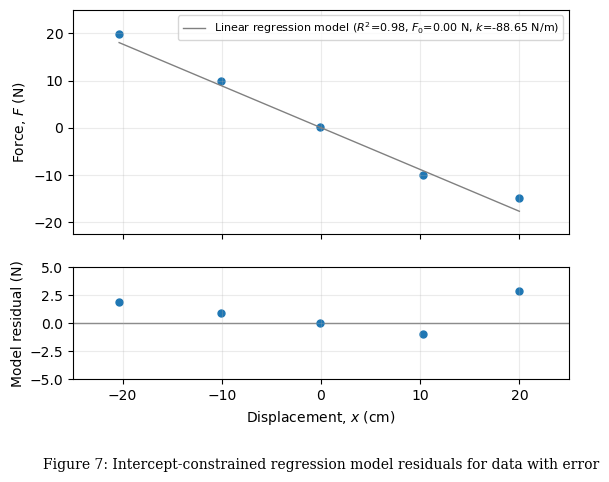

In [6]:
# fit linear regression model, constraining intercept to 0
regressor = LinearRegression(fit_intercept=False)
regressor.fit(data_error['x'].to_frame().values, data_error['F'].values)

# now, we use the model to predict the force at the displacement measurement points
data_model = data_error.copy(deep=True)
data_model['F'] = regressor.predict(data_model['x'].to_frame().values)

# Create figure and add Gridspec subplot array
fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=(2,1))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)

# Plot measurement data in top chart
data_error.plot.scatter(x='x', y='F', ax=ax0, s=25)

# plot regression model line
plot_and_format_regression_line(regressor, data_error['x'].to_frame().values, data_error['F'].values, ax0)

ax0.set_ylabel('Force, $F$ (N)')
ax0.set_xlim(-25, 25)
ax0.set_ylim(-22.5, 25)
ax0.legend(fontsize=8)
ax0.grid(alpha=0.25)

# Calculate and plot residuals (predicted - actual) in bottom chart
data_res = data_error.copy(deep=True)
data_res['F'] = data_error['F'].subtract(data_model['F'])

data_res.plot.scatter(x='x', y='F', ax=ax1, s=25)

ax1.set_xlabel(f'Displacement, $x$ (cm)')
ax1.set_ylabel('Model residual (N)')
ax1.set_ylim(-5, 5)
ax1.grid(alpha=0.25)
ax1.axhline(0, color='grey', lw=1, zorder=-1)

caption = "Figure 7: Intercept-constrained regression model residuals for data with error"
plt.text(.5, -.8, caption, ha='center', font='serif', fontweight='medium', transform=ax1.transAxes)
plt.show()


This is slightly better - the fifth point model residual has the largest absolute value. However, it's not a huge margin over the other points and we'd still have a hard time reliably identifying the anomaly (in order to remove the fifth data point and retrain the model) and not risk misclassifying other non-erroneous data points. As it stands, the model is still a fairly poor fit to the data and the slope is still a long way off the nominal spring constant of 100 N/m.

We can also consider another example, in which we deliberately impart a systematic bias onto the force measurement values. In practical terms, this could for example arise due to an incorrectly calibrated force gauge.

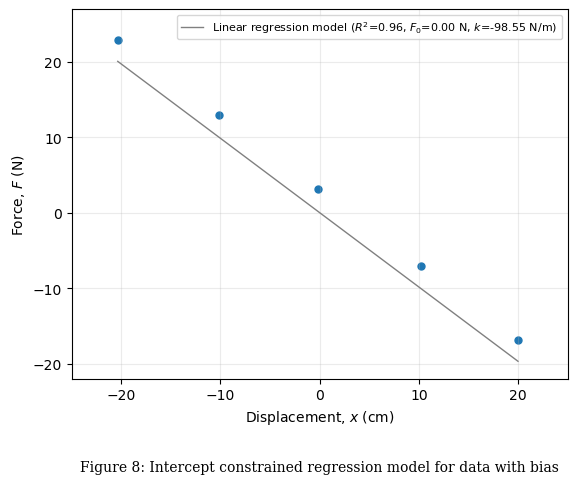

In [7]:
# create dataset with systematic measurement bias in Force values
data_bias = data.copy(deep=True)
data_bias['F'] += 3    # +3 N bias in force measurements introduced

# fit linear regression model
regressor = LinearRegression(fit_intercept=False) # set intercept to 0 (only works for centred data)
regressor.fit(data_bias['x'].to_frame().values, data_bias['F'].values)

# now, we use the model to predict the force at the displacement measurement sample points
data_model = data_bias.copy(deep=True)
data_model['F'] = regressor.predict(data_model['x'].to_frame().values)

# Plot measurement data
ax = data_bias.plot.scatter(x='x', y='F', s=25)

# plot regression model line
plot_and_format_regression_line(regressor, data_bias['x'].to_frame().values, data_bias['F'].values, ax)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-22, 27)
ax.legend(fontsize=8)
plt.grid(alpha=0.25)

caption = "Figure 8: Intercept constrained regression model for data with bias"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

This is clearly unsatisfactory - the model is a poor predictor of the measurement data and is clearly biased even though the model slope is very close to the nominal spring constant of 100 N/m.

## A physics-informed approach to linear regression modelling

We have so far identified two data quality issues that we'd want our modelling system to handle: anomalous data points and systematically biased measurements.

Starting with the biased measurements: we can incorporate the unknown biases into the model directly as additional parameters which can then be solved for during the model fitting. We can potentially have unknown biases in *both* the force and displacement measurements - so say $\delta$ is the unknown bias in the force measurements, and $\epsilon$ is the unknown bias in the displacement measurements. 

We can "correct" the data by subtracting the intrinsic biases from the measurement values. Therefore, we can rewrite our physical model as:
$$(F - \delta) = -k (x - \epsilon) \tag{2}$$

We now have three unknown parameters to fit to the data ($k$, $\delta$ and $\epsilon$) rather than just one. To simplify things, lets define the intercept of the linear model as $\lambda = \delta + k\epsilon$ and rearrange the equation to give:
$$F = -k x + \lambda \tag{3}$$

This reduces the problem to a recognisable linear equation. Unfortunately the intercept parameter, $\lambda$, isn't particularly physically meaningful, because it could be due to biases in either the force or displacement measurements (or a combination of both). To determine which measurement axis is contributing to any observed bias would require a more creative approach but for now we'll settle with being able to detect any measurement bias. 

We can now re-run our previous example involving a systematic measurement bias, this time with the intercept not constrained to 0.

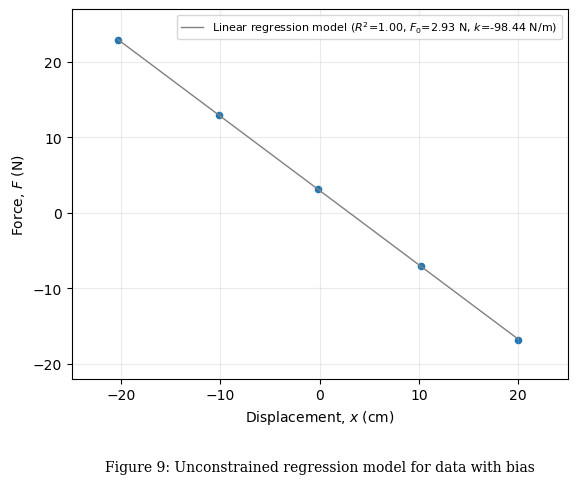

In [8]:
# run unconstrained linear regression model
regressor = LinearRegression()
regressor.fit(data_bias['x'].to_frame().values, data_bias['F'].values)

# now, we use the model to predict the force at the displacement measurement points
data_model = data_bias.copy(deep=True)
data_model['F'] = regressor.predict(data_model['x'].to_frame().values)

# Plot measurement data
ax = data_bias.plot.scatter(x='x', y='F')

# plot regression model line
plot_and_format_regression_line(regressor, data_bias['x'].to_frame().values, data_bias['F'].values, ax)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-22, 27)
ax.legend(fontsize=8)
plt.grid(alpha=0.25)

caption = "Figure 9: Unconstrained regression model for data with bias"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

As expected, the unconstrained model fits the data well and the model parameters for the slope, $k$, and intercept, $\lambda$, closely match the nominal spring coefficient and the deliberately introduced bias.

### Defining a cost function for least squares linear regression

So far we have relied on the scikit-learn library for fitting linear regression models to our example data. Since we want to further explore options for integrating our physics-based model into this modelling process, we will have to look behind the scenes at the linear regression process and implement our own functions for optimising the parameters. 

Firstly, in order to make the parameter notation more generalised, let's rewrite out physics-based model as:
$$y = F(x) = {\theta}_0 + {\theta}_1 x \tag{4}$$
where ${\theta}_0 = F(0)$ is the model intercept term (meaning the force in the spring when the displacement is at 0 cm) and ${\theta}_1 = -k$ is the slope of our linear x-y model and equal to the negative value of the spring constant, $k$.

As the name implies, least squares regression aims to optimise the model parameters (${\theta}_0$ and ${\theta}_1$) in order to minimise the mean square of the errors of the data points available, with the error for each point being the residual difference between the actual measurement of force and the regression model's predicted value.

We can describe the total of the square errors as a "cost function", $J({\theta}_0, {\theta}_1)$, since it is a function of the two parameters that we are trying to optimise in the model fitting process. We can therefore express our cost function in the following terms.

$$J({\theta}_0, {\theta}_1) = \frac{1}{N} \sum_{i=1}^{N} (y_i - ({\theta}_0 + {\theta}_1 x_i))^2 \tag{5}$$

Since we are squaring the errors, we can see that if we were to expand this equation the full expression would include positive terms for the squares of the model parameters (i.e. ${\theta}_0^2$ and ${\theta}_1^2$). Therefore, if we were to adjust either ${\theta}_0$ or ${\theta}_1$ far away from the optimal value, then the cost function will increase proportionally to the square of the term being adjusted. In short, we can see that the cost function expressed in these terms is a 2-dimensional concave parabolic surface, which is therefore guaranteed to have a single, global minimum. Further, this global minimum is the only point on the surface at which the gradient along either axis is 0.

There is some further explanation of this (with example diagrams of the cost function) here: [A quick review of linear regression](https://explained.ai/regularization/intro.html) (there's also a bit about regularisation which we'll come onto later).

### A direct solution for least squares regression using linear algebra

As we described above, we now have defined a cost function for which we know there is a global minimum where the gradient along both axes (those of the two model parameters) is 0. We will use this fact together with some partial derivatives in order to derive a solution for the optimised parameters directly (so without having to perform any form of costly iterative optimisation process such as gradient descent). 

First, we can take the partial derivatives of the cost function equation with respect to both ${\theta}_0$ and ${\theta}_1$. We'll write these equations as equal to 0, since that is true at the optimisation point that we are trying to solve for.
$$ \frac{\partial J({\theta}_0, {\theta}_1)}{\partial {\theta}_0} = -\frac{2}{N} \sum_{i=1}^{N}(y_i - ({\theta}_0 + {\theta}_1 x_i)) = 0 \tag{6}$$

$$ \frac{\partial J({\theta}_0, {\theta}_1)}{\partial {\theta}_1} = -\frac{2}{N} \sum_{i=1}^{N}(y_i - ({\theta}_0 + {\theta}_1 x_i))x_i = 0 \tag{7}$$

Next, we can divide each equation by $\frac{-2}{N}$ since the equations are equal to 0 so that is an unnecessary scale factor. We can then expand the summation expression and rearrange to produce the following equations (the intermediate steps are left as an exercise for the reader).

$$ N {\theta}_0 + \left( \sum_{i=1}^{N}x_i \right)  {\theta}_1 = \sum_{i=1}^{N}y_i \tag{8}$$ 

$$  \left( \sum_{i=1}^{N}x_i \right){\theta}_0 + \left( \sum_{i=1}^{N}x_i^2 \right)  {\theta}_1 = \sum_{i=1}^{N}y_i x_i \tag{9}$$ 

This pair of equations can be expressed in vectorised form:

$$\begin{bmatrix} N & \sum_{i=1}^{N}x_i \\  \sum_{i=1}^{N}x_i & \sum_{i=1}^{N}x_i^2 \end{bmatrix} \begin{bmatrix} {\theta}_0 \\ {\theta}_1 \end{bmatrix} = \begin{bmatrix} \sum_{i=1}^{N}y_i \\ \sum_{i=1}^{N}y_i x_i \end{bmatrix} \tag{10}$$ 

If we call the 2 $\times$ 2 matrix $\textbf{A}$, the left hand side vector $\boldsymbol{\theta}$ and the right hand side vector $\textbf{b}$, then this equation is in the generalised form
$$ \textbf{A } \boldsymbol{\theta}= \textbf{b} \tag{11}$$

If matrix $\textbf{A}$ happens to be an [invertible matrix](https://en.wikipedia.org/wiki/Invertible_matrix), then we can call the inverse matrix $\mathbf{A^{-1}}$. We can therefore multiply both sides of the equation by the inverse matrix $\mathbf{A^{-1}}$ to give:
$$ \mathbf{A^{-1}} \textbf{A} \boldsymbol{\theta} = \mathbf{A^{-1}}\textbf{b} \tag{12}$$

Since a matrix multiplied by its inverse is the identity matrix, we can reduce this equation down to:
$$ \boldsymbol{\theta} = \mathbf{A^{-1}}\textbf{b} \tag{13}$$

This is our generalised equation for solving for the optimised values of ${\theta}_0$ and ${\theta}_1$. We'll now define our own function to solve this equation, and test it on one of the datasets we were working with earlier. Note that we aren't performing the matrix inverse explicitly here but instead relying on the Numpy matrix inverse function - we'll include a try/except clause to catch any occasions when this function fails to invert the matrix.

In [9]:
def fit_lin_regr_params(x: np.array, y: np.array) -> tuple:
    """Fits ordinary least squares regression for input arrays of data x and y,
    satisfying the equation:
        y = theta0 + theta1*x

    Args:
        x (np.array): One dimensional numerical array of length N
        y (np.array): One dimensional numerical array of length N

    Returns:
        tuple: Linear regression model parameters (theta0, theta1)
    """

    N = x.size

    # Construct 2x2 matrix from elements
    a = N
    b = np.sum(x)
    c = np.sum(x)
    d = np.sum(x**2)

    A = np.array([
        [a, b],
        [c, d]
    ])
    
    # Invert the matrix if possible
    try:
        A_inv = np.linalg.inv(A)
    except np.linalg.LinAlgError as err:
        raise

    # RHS right hand side vector (b in equation derivation)
    RHS = np.array([
        np.sum(y), 
        np.sum(y*x)
    ]).T

    # Calculate and return optimised theta parameters
    theta0, theta1 = np.matmul(A_inv, RHS)
    
    return theta0, theta1

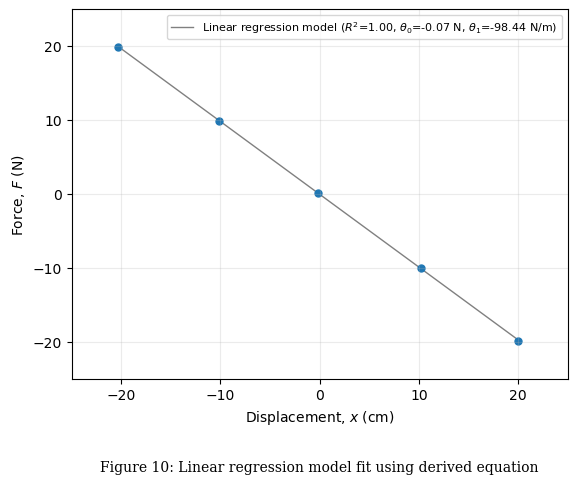

In [10]:
# Plot original artifical measurement data
ax = data.plot.scatter(x='x', y='F', s=25)

# # Fit and plot linear regression model
theta0, theta1 = fit_lin_regr_params(data['x'].values, data['F'].values)
data_model = data.copy(deep=True)
data_model['F'] = theta0 + theta1*data_model['x']

reg_score =  "%.2f" % r2_score(data['F'], data_model['F'])
reg_int = "%.2f" % theta0
reg_slope = "%.2f" % (100*theta1) # convert to N/m
model_label = rf'Linear regression model ($R^2$={reg_score}, $\theta_0$={reg_int} N, $\theta_1$={reg_slope} N/m)'

data_model.plot(x='x', y='F', ax=ax, lw=1, label=model_label, color='grey', zorder=-1)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.legend(fontsize=8)
plt.grid(alpha=0.25)

caption = "Figure 10: Linear regression model fit using derived equation"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

Success! The values for $R^2$, ${\theta}_0$ and ${\theta}_1$ all match the scikit-learn model that we fitted to this dataset previously (see Figure 4), which confirms that our regression function derivation and implementation has worked as expected. 

### Regularised linear regression and custom loss functions

Now that we are able to implement our own linear regression solver functions, we can explore methods to adapt our hybrid model to better handle erroneous measurement data. 

Firstly, we can consider the example of systematically biased measurements. We have introduced a model intercept parameter, $\lambda$, to represent the combined measurement bias in the two measurement parameters.

At this stage, we need to consider our relative levels of confidence in the measurement data versus the physics-based model. On one hand, the physics-based model is based on well understood physics and we can have some confidence that the real behaviour should be something fairly close to it. On the other hand, the physics-based model cannot be perfect - it excludes some potentially relevant parameters (such as temperature) as well as other unknowns such as measurement biases. 

In contrast, the measurement data is our best available 'truth' of the behaviour of the system - since these are taken from the physical system any relevant factors will naturally be represented. However, some of these factors could be procedural rather than physical, such as measurement inaccuracies or sensor calibration errors. Therefore, the data values only necessarily reflect the "measured reality" rather than the physical reality of the system, with an unknown function relating the two.

When we have very little data, for example one data point, we have little confidence in the data due to uncertainties in the relationship between the measured reality and physical reality. We therefore have relatively more confidence in the physics-based model than the measurement data at this stage - if we wanted to make predictions about the system behaviour outside the observed range we would be better off relying on the former than the latter. 

As we collect more measurement points, some of the uncertainties in the measured reality are reduced. For example, any data-driven model derived from the measurements will naturally be more robust against random measurement noise which could produce large errors on individual data points. Systematic measurement biases will still be present but those could be interpreted as being part of the physical reality - we are just changing the definitions of the model variables within our hybrid model to account for them. 

In summary, we are saying that with only a small about of data we have more confidence in the physics-based model (but we cannot ignore the data), and with lots of measurements we have more confidence in the measurements (but we cannot ignore the model).

If we are taking measurements sequentially over time, we can visualise how the relativel confidence in the data vs the physics-based model changes over time. 

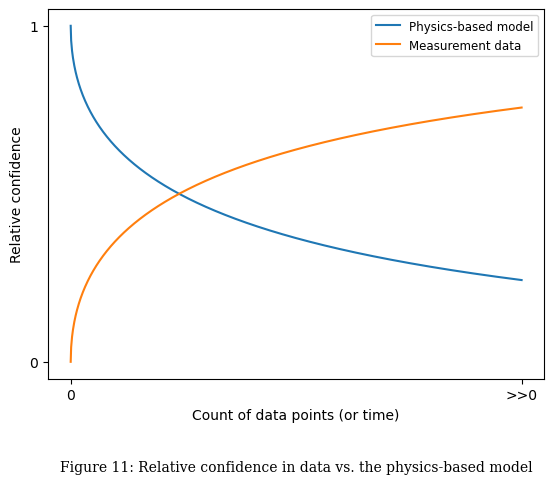

In [11]:
X = np.arange(1000, dtype=float)
Y = np.exp(-(X/500)**(0.5))

fig, ax  = plt.subplots()

ax.plot(X, Y, label='Physics-based model')
ax.plot(X, 1 - Y, label='Measurement data')

ax.set_xticks([0, 1000])
ax.set_yticks([0, 1])

ax.set_xticklabels([0, '>>0'])

ax.set_xlabel('Count of data points (or time)')
ax.set_ylabel('Relative confidence')
ax.legend(fontsize=8.5)

caption = "Figure 11: Relative confidence in data vs. the physics-based model"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)

plt.show()


Now, this is just for illustration purposes, so the actual scale of this transition is ambiguous, but it does provide some guidance as to how we might want our hybrid model to behave.

Regularisation is a technique used in machine learning applications to prevent overfitting - the typical approach is to apply a penalty to the cost function for the higher dimensional terms. This prevents the higher dimension terms being given a high weighting when only a small amount of data is available - as we expect some measurement noise in the individual points, we don't want to give the regression model carte blanche to use all available terms to produce a model which perfectly fits the data. This will produce a more constrained model which may appear to underfit the model, but as we receive more data points we expect that they should better match this constrained model. However, as we re-train on the additional data points, the sum of squared errors will begin to dominate the regularisation term in the cost function and so the model will have more freedom to make full use of the higher dimensional terms. 

There is a clear parallel between model regularisation and the confidence transition that we described above - in both cases, we take a modelling approach which gives the data increasingly more weight as more data points become available.

## Regularised linear regression modelling of our example spring measurement system

Now that we have an idea of how regularisation can be used in regression modelling to represent (and apply a weighting to) knowledge of a physical system, lets try to implement this approach to our example spring force-displacement measurement system.

### Regularisation of model intercept parameter in regression model

To start off, we will focus on the regularisation of the model intercept parameter, ${\theta}_0$. This will be useful in the presence of any systematic measurement biases - ideally we would be skeptical about any apparent bias in the data when only a few measurements are available but accept it when more data becomes available which further points to its existance.


Firstly, we should consider what we actually want to regulate with regards to ${\theta}_0$. Nominally, we expect by default for there to be no systematic measurement bias - therefore the expected value of ${\theta}_0$ should be zero. We can denote this expected value ${\theta}_0'$. We want to add a penalty term to the regularisation cost function for when the value of the parameter ${\theta}_0$ is far away from this expected value (in either direction). A reasonable way to do this is to add a squared error term, $({\theta}_0 - {\theta}_0')^2$.

$$J({\theta}_0, {\theta}_1) = \frac{1}{N} \left( \sum_{i=1}^{N} (y_i - ({\theta}_0 + {\theta}_1 x_i))^2 \right) + ({\theta}_0 - {\theta}_0')^2 \tag{14}$$

However, we have no explicit control over the relative weighting of the sum squared error (SSE) term versus this ${\theta}_0$ squared error term. We can therefore multiply the latter by a weight parameter, $\alpha$, which will give us that control. 

$$J({\theta}_0, {\theta}_1) = \frac{1}{N} \left( \sum_{i=1}^{N} (y_i - ({\theta}_0 + {\theta}_1 x_i))^2 \right) + \alpha ({\theta}_0 - {\theta}_0')^2 \tag{15}$$

This still doesn't seem quite right. The $1/N$ term is normalising the SSE term againt the number of data points - in theory this should stay more-or-less constant as the number of points, $N$, increases. Similarly, the ${\theta}_0$ squared error term is just multiplied by a constant - it is also independent of the number of data points. However, we want the relative importance of the SSE term to grow as the number of data points increases. One approach is simply to remove the $1/N$ term.

$$J({\theta}_0, {\theta}_1) = \left( \sum_{i=1}^{N} (y_i - ({\theta}_0 + {\theta}_1 x_i))^2 \right) + \alpha ({\theta}_0 - {\theta}_0')^2 \tag{16}$$

In this case, the SSE term will increase roughly in proportion to $N$, whereas the ${\theta}_0$ squared error term will stay constant. This seems a bit too aggressive - as we gain more data the ${\theta}_0$ squared error (and hence the "physics knowledge" of that component of the model) will rapidly be lost. As a leap-of-faith approach we can imcorporate another parameter, $N^\mu$, with which we can control the speed at which the ${\theta}_0$ squared error is de-weighted as $N$ increases. We will fix $\mu$ somewhere in the range $0 < \mu < 1$. A trial-and-error approach will have to be taken to get reasonable values for the $\alpha$ and $\mu$ terms.

$$J({\theta}_0, {\theta}_1) =  \left( \sum_{i=1}^{N} (y_i - ({\theta}_0 + {\theta}_1 x_i))^2 \right) + \alpha N^\mu ({\theta}_0 - {\theta}_0')^2 \tag{17}$$

This is our regularised cost function. Next is to derive a function for evaluating the optimal model parameters. We will take a similar approach as in Section 3.2.2 - first we will take the partial derivatives with respect to the two model parameters, set each partial derivative equal to zero, and then rearrange into a matrix expression that can be solved using linear algebra.

The partial derivatives of our regularised cost function are as follows. 

$$ \frac{\partial J({\theta}_0, {\theta}_1)}{\partial {\theta}_0} = -2 \left( \sum_{i=1}^{N}(y_i - ({\theta}_0 + {\theta}_1 x_i)) \right) + 2\alpha N^\mu ({\theta}_0 - {\theta}_0')= 0 \tag{18}$$

$$ \frac{\partial J({\theta}_0, {\theta}_1)}{\partial {\theta}_1} = -2 \left( \sum_{i=1}^{N}(y_i - ({\theta}_0 + {\theta}_1 x_i))x_i \right) = 0 \tag{19}$$

Dividing both of these equations by -2 and then rearranging, we get:

$$(N + \alpha N^\mu){\theta}_0 + \left( \sum_{i=1}^{N} x_i \right) {\theta}_1 = \left( \sum_{i=1}^{N} y_i \right) + \alpha N^\mu {\theta}_0' \tag{20}$$

$$ \left( \sum_{i=1}^{N} x_i \right){\theta}_0  + \left( \sum_{i=1}^{N} x_i^2 \right) {\theta}_1 = \sum_{i=1}^{N} y_i x_i \tag{21}$$

This pair of equations can be represented in vectorised form:

$$\begin{bmatrix} (N + \alpha N^\mu) & \sum_{i=1}^{N} x_i \\ \sum_{i=1}^{N} x_i & \sum_{i=1}^{N} x_i^2 \end{bmatrix} \begin{bmatrix} {\theta}_0 \\ {\theta}_1 \end{bmatrix} = \begin{bmatrix} \left( \sum_{i=1}^{N} y_i \right) + \alpha N^\mu {\theta}_0' \\ \sum_{i=1}^{N}y_i x_i \end{bmatrix} \tag{22}$$

Again we can consider this matrix equation in generalised form $ \textbf{A }\boldsymbol{\theta}= \textbf{b} $, which can be rearranged to the form $ \boldsymbol{\theta} = \mathbf{A^{-1}}\textbf{b} $ via matrix inversion. As we did previously, we'll write our own regularised linear regression solver function.

In [12]:
def fit_lin_regr_params_regul_theta0(
        x: np.array, 
        y: np.array, 
        alpha: float = 0, 
        mu: float = 0.5,
        theta0_prime: float = 0
    ) -> tuple:
    """Fits ordinary least squares regression for input arrays of data x and y,
    satisfying the equation:
        y = theta0 + theta1*x

    Includes optional parameters to control the regularisation of the model 
    intercept parameter, theta0.

    Args:
        x (np.array): One dimensional numerical array of length N
        y (np.array): One dimensional numerical array of length N
        alpha (float, optional): Intercept parameter regularisation weight. 
            Defaults to 0.
        mu (float, optional): Intercept parameter regularisation transition
            speed factor. Defaults to 0.0. (limit to range 0 < mu < 1). 
        theta0_prime (float, optional): Intercept nominal value used in 
            regularisation. Defaults to 0.

    Returns:
        tuple: Linear regression model parameters (theta0, theta1)
    """
    
    N = x.size

    # Construct 2x2 matrix from elements
    a = N + alpha*(N**mu)
    b = np.sum(x)
    c = np.sum(x)
    d = np.sum(x**2)

    A = np.array([
        [a, b],
        [c, d]
    ])

    # Invert the matrix if possible
    try:
        A_inv = np.linalg.inv(A)
    except np.linalg.LinAlgError as err:
        raise
    
    # RHS right hand side vector (b in equation derivation)
    RHS = np.array([
        np.sum(y) + alpha*(N**mu)*theta0_prime,
        np.sum(y*x)
    ]).T

    # Calculate and return optimised theta parameters
    theta0, theta1 = np.matmul(A_inv, RHS)
    
    return theta0, theta1

### Application of regularised intercept parameter regression model

Now we'll apply the regularised linear regression solver to the biased sample data that we were using previously. 

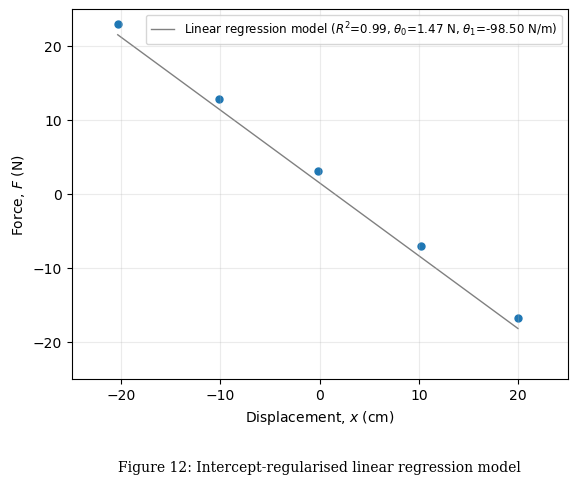

In [13]:
# Plot original artifical measurement data
ax = data_bias.plot.scatter(x='x', y='F', s=25)

# Set regularisation parameters
alpha=5
mu=0
theta0_prime=0

# Fit and plot linear regression model
theta0, theta1 = fit_lin_regr_params_regul_theta0(data_bias['x'].values, data_bias['F'].values, alpha, mu, theta0_prime)
data_model = data_bias.copy(deep=True)
data_model['F'] = theta0 + theta1*data_model['x']

reg_score =  "%.2f" % r2_score(data_bias['F'], data_model['F'])
reg_int = "%.2f" % theta0
reg_slope = "%.2f" % (100*theta1) # convert to N/m
model_label = rf'Linear regression model ($R^2$={reg_score}, $\theta_0$={reg_int} N, $\theta_1$={reg_slope} N/m)'

data_model.plot(x='x', y='F', ax=ax, lw=1, label=model_label, color='grey', zorder=-1)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.legend(fontsize=8.5)
plt.grid(alpha=0.25)

caption = "Figure 12: Intercept-regularised linear regression model"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()


Again, success! Our function has produced a model which is clearly somewhere between the unregularised version and the pure physics-constrained approach (which discounted any measurement biases and constrained the intercept to 0). In fact the intercept parameter, ${\theta}_0$, is approx. 1.5, which is roughly half of the measurement data bias we introduced (which was 3). Therefore, the values of $\alpha$ and $\mu$ are such that we are close to the transition point - the point after which more data points leads to us having more confidence in the data values than the physics-based model (which says the expected value of the intercept should be 0).

This is looking promising. It is worth doing some further experimentation to see whether our theories about the transition from physics-model biased to data-biased as the data points increase hold up. To do this, we'll duplicate the data points we already have integer numbers of times to scale up the data point count without otherwise impacting the statistics. Hopefully, this should enable us to track the transition from physics-model biased (${\theta}_0$ close to 0) to data biased (${\theta}_0$ close to 3).

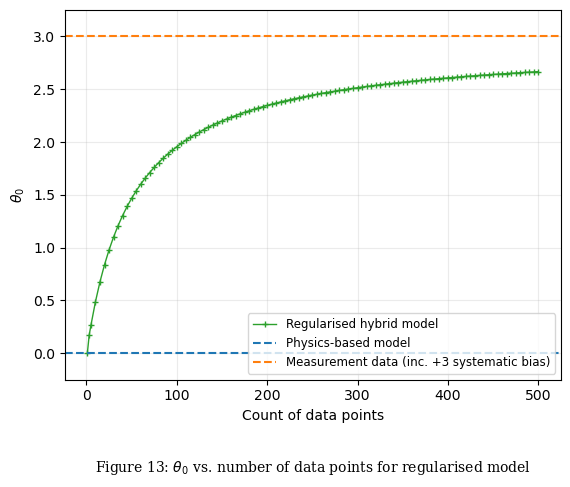

In [14]:
# Define helper function 
def simulate_regress_function_with_dupl_data(data, func, **kwargs):
    param_log = {}

    # start with single data point, and add to log
    theta0, theta1 = func(data['x'].values[2], data['F'].values[2], **kwargs) #alpha, mu, theta0_prime)
    param_log[1] = {'theta0': theta0, 'theta1': theta1}

    # 3 data points
    theta0, theta1 = func(data['x'].values[1:4], data['F'].values[1:4], **kwargs) # alpha, mu, theta0_prime)
    param_log[3] = {'theta0': theta0, 'theta1': theta1}

    for i in range(1, 101):
        # repeat data points i times
        data_i = pd.DataFrame(np.repeat(data.values, i, axis=0), columns=data.columns)

        # Fit and plot linear regression model, and add to log
        theta0, theta1 = func(data_i['x'].values, data_i['F'].values, **kwargs) # alpha, mu, theta0_prime)
        param_log[5*i] = {'theta0': theta0, 'theta1': theta1}

    param_log_df = pd.DataFrame(param_log).T

    return param_log_df

# Set regularisation parameters
alpha=50
mu=0.
theta0_prime=0

# run simulation function
param_log_df = simulate_regress_function_with_dupl_data(data_bias, fit_lin_regr_params_regul_theta0, alpha=alpha, mu=mu, theta0_prime=theta0_prime)

# plot
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax = param_log_df['theta0'].plot(label='Regularised hybrid model', c=colours[2], marker='+', ms=5, lw=1)
ax.set_xlabel('Count of data points')
ax.set_ylabel(rf'$\theta_0$')
ax.set_ylim(-0.25, 3.25)

ax.axhline(0, ls='--', label='Physics-based model')
ax.axhline(3, ls='--', label='Measurement data (inc. +3 systematic bias)', c=colours[1])
ax.legend(fontsize=8.5, loc=4)

plt.grid(alpha=0.25)

caption = rf"Figure 13: $\theta_0$ vs. number of data points for regularised model"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

Here we can see that the regularised hybrid model starts off with a ${\theta}_0$ value of ~0 when there are very few data points available. This quickly starts to change as more data points are added - the hybrid model ${\theta}_0$ value trends asymptotically towards the measurement data bias of +3. 

The rate at which this trending occurs can be changed by adjusting the $\alpha$ and $\mu$ parameters - in this example we have set $\mu$ to 0 (the bottom of the acceptable range) in order to achieve a more rapid shift in favour of the measurement data. Even so, with 500 data points the ${\theta}_0$ is still only 2.8, so ~7% away from the 'true' (biased) value - this could be optimised by further reducing the $\alpha$ parameter.

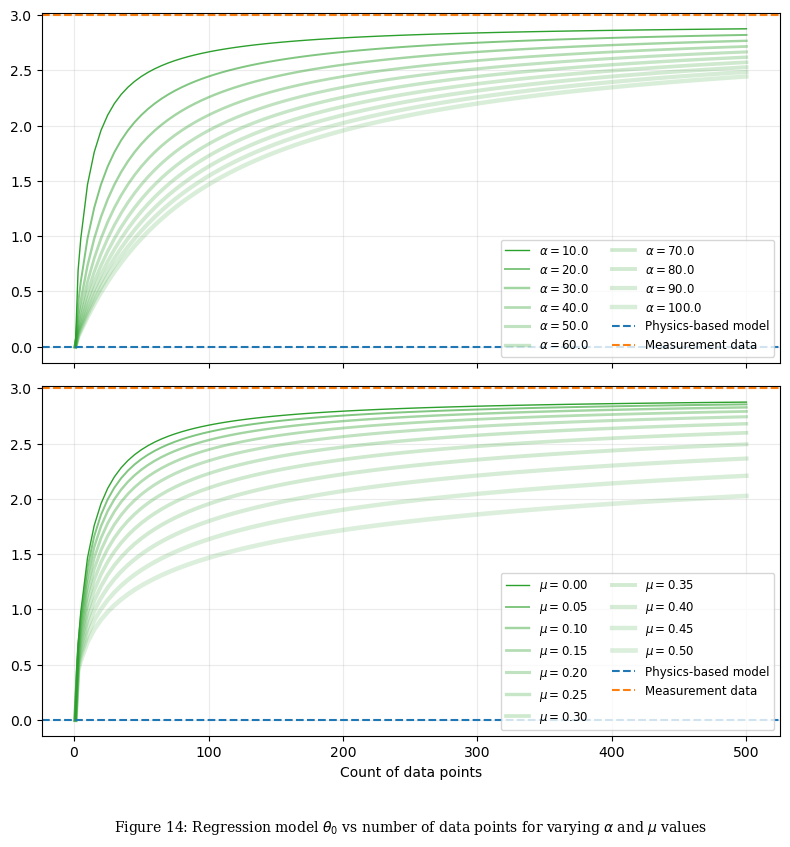

In [15]:
# Set regularisation parameter defaults
alpha=10
mu=0.
theta0_prime=0

# define range of alpha vals to iterate over
alpha_vals = np.arange(10, 110, step=10, dtype=float)
alpha_log = {}
for j, alpha_val in enumerate(alpha_vals):
    param_log_df = simulate_regress_function_with_dupl_data(data_bias, fit_lin_regr_params_regul_theta0, alpha=alpha_val, mu=mu, theta0_prime=theta0_prime)
    alpha_log[alpha_val] = param_log_df

mu_vals = np.arange(0, 0.55, 0.05, dtype=float)
mu_log = {}
for j, mu_val in enumerate(mu_vals):
    param_log_df = simulate_regress_function_with_dupl_data(data_bias, fit_lin_regr_params_regul_theta0, alpha=alpha, mu=mu_val, theta0_prime=theta0_prime)
    mu_log[mu_val] = param_log_df

# plot
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

for j, alpha_val in enumerate(alpha_log.keys()):
    alpha_log[alpha_val]['theta0'].plot(ax=axarr[0], label=rf'$\alpha=${alpha_val}', c=colours[2], lw=(j+1)**0.5, alpha=(1/(j+1))**0.75)

for j, mu_val in enumerate(mu_log.keys()):
    mu_log[mu_val]['theta0'].plot(ax=axarr[1], label=rf'$\mu=$' + '%.2f' % mu_val, c=colours[2], lw=(j+1)**0.5, alpha=(1/(j+1))**0.75)

for ax in axarr:
    ax.axhline(0, ls='--', label='Physics-based model')
    ax.axhline(3, ls='--', label='Measurement data', c=colours[1])
    ax.legend(fontsize=8.5, ncol=2, loc=4)
    ax.grid(alpha=0.25)

axarr[1].set_xlabel('Count of data points')
plt.tight_layout()

caption = rf"Figure 14: Regression model $\theta_0$ vs number of data points for varying $\alpha$ and $\mu$ values"
plt.text(.5, -.275, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)

plt.show()

Here we see that the regularised ${\theta}_0$ value trends towards that of the measurement data for all regularisation parameter configurations, but the values of which change the rate and shape of that trend. Increasing the value of either $\alpha$ or $\mu$ decreases the rate at which the data characteristics take over from the physics model - that is as expected due to our design of the cost function. 

However, there is a clear difference in behaviour when varying the $\alpha$ vs the $\mu$ parameters. In particular, the range of $\mu$ values tested show a higher spread in ${\theta}_0$ value behaviour within the first phase (i.e. the first 20 or so data points), in comparison to the $\alpha$ values. There are also differences in the latter phases - the larger $\mu$ values "flatten out" the ${\theta}_0$ values after ~100 points, in comparison to the larger $\alpha$ values. This in an interesting observation - the optimal combination of parameter values likely depends on the desired behaviour in a particular situation. 

### Regularisation of both the model intercept and slope parameters

The obvious next step is to add in a regularisation term for the model slope, ${\theta}_1$, in to the linear regression model cost function. Following a similar thought process to that take for the model intercept, we can incorporate our physics-based knowledge by defining an expected value of the model slope, ${\theta}_1'$. We recall that the value used to simulate our test data was 100 N/m. Thus, our cost function becomes:

$$J({\theta}_0, {\theta}_1) =  \left( \sum_{i=1}^{N} (y_i - ({\theta}_0 + {\theta}_1 x_i))^2 \right) + \alpha N^\mu ({\theta}_0 - {\theta}_0')^2 + \beta N^\nu ({\theta}_1 - {\theta}_1')^2 \tag{23}$$

Again taking the partial dervatives with respect to each regression parameter gives us:

$$ \frac{\partial J({\theta}_0, {\theta}_1)}{\partial {\theta}_0} = -2 \left( \sum_{i=1}^{N}(y_i - ({\theta}_0 + {\theta}_1 x_i)) \right) + 2\alpha N^\mu ({\theta}_0 - {\theta}_0')= 0 \tag{24}$$

$$ \frac{\partial J({\theta}_0, {\theta}_1)}{\partial {\theta}_1} = -2 \left( \sum_{i=1}^{N}(y_i - ({\theta}_0 + {\theta}_1 x_i))x_i \right) +2\beta N^\nu ({\theta}_1 - {\theta}_1')= 0 \tag{25}$$

Dividing each equation by -2 and rearranging, we get:

$$(N + \alpha N^\mu){\theta}_0 + \left( \sum_{i=1}^{N} x_i \right) {\theta}_1 = \left( \sum_{i=1}^{N} y_i \right) + \alpha N^\mu {\theta}_0' \tag{26}$$

$$ \left( \sum_{i=1}^{N} x_i \right){\theta}_0  + \left(\left( \sum_{i=1}^{N} x_i^2 \right) + \beta N^\nu \right) {\theta}_1 = \left( \sum_{i=1}^{N} y_i x_i \right) + \beta N^\nu {\theta}_1'\tag{27}$$

As before, this pair of equations can be represented in vectorised form:

$$\begin{bmatrix} (N + \alpha N^\mu) & \sum_{i=1}^{N} x_i \\ \sum_{i=1}^{N} x_i &  \left( \sum_{i=1}^{N} x_i^2 \right) + \beta N^\nu \end{bmatrix} \begin{bmatrix} {\theta}_0 \\ {\theta}_1 \end{bmatrix} = \begin{bmatrix} \left( \sum_{i=1}^{N} y_i \right) + \alpha N^\mu {\theta}_0' \\ \left( \sum_{i=1}^{N}y_i x_i \right) + \beta N^\nu {\theta}_1' \end{bmatrix} \tag{28}$$

We are now in a position to define our linear regression solver function which incorporates this regularisation of both ${\theta}_0$ and ${\theta}_1$. We will go in to fit this regularised regression model to our synthetic dataset, where we start off by assuming our physics-based knowledge of the spring constant is 80 N/m, which differs from the value used to generate the data (100 N/m).

In [16]:
def fit_lin_regr_params_regul_theta0_theta1(
        x: np.array, 
        y: np.array, 
        alpha: float = 1,
        mu: float = 0,
        theta0_prime: float = 0, 
        beta: float = 1,
        nu: float = 0,
        theta1_prime: float = 0
    ) -> tuple:
    """Fits ordinary least squares regression for input arrays of data x and y,
    satisfying the equation:
        y = theta0 + theta1*x

    Includes optional parameters to control the regularisation of the model 
    intercept parameter theta0 and slope parameter theta1.

    Args:
        x (np.array): One dimensional numerical array of length N
        y (np.array): One dimensional numerical array of length N
        alpha (float, optional): Intercept parameter regularisation weight. 
            Defaults to 0.
        mu (float, optional): Intercept parameter regularisation transition
            speed factor. Defaults to 0.0. (limit to range 0 < mu < 1).
        theta0_prime (float, optional): Intercept nominal value used in 
            regularisation. Defaults to 1.
        beta (float, optional): Slope parameter regularisation weight. 
            Defaults to 0.
        nu (float, optional): Slope parameter regularisation transition
            speed factor. Defaults to 0.0. (limit to range 0 < nu < 1).
        theta1_prime (float, optional): Slope nominal value used in 
            regularisation. Defaults to 1.

    Returns:
        tuple: Linear regression model parameters (theta0, theta1)
    """

    N = x.size

    # Construct 2x2 matrix from elements
    a = N + alpha*(N**mu)
    b = np.sum(x)
    c = np.sum(x)
    d = np.sum(x**2) + beta*(N**nu)

    A = np.array([
        [a, b],
        [c, d]
    ])

    # Invert the matrix if possible
    try:
        A_inv = np.linalg.inv(A)
    except np.linalg.LinAlgError as err:
        raise

    # RHS right hand side vector (b in equation derivation)
    RHS = np.array([
        np.sum(y) + alpha*(N**mu)*theta0_prime,
        np.sum(y*x) + beta*(N**nu)*theta1_prime
    ]).T

    # Calculate and return optimised theta parameters
    theta0, theta1 = np.matmul(A_inv, RHS)
    
    return theta0, theta1

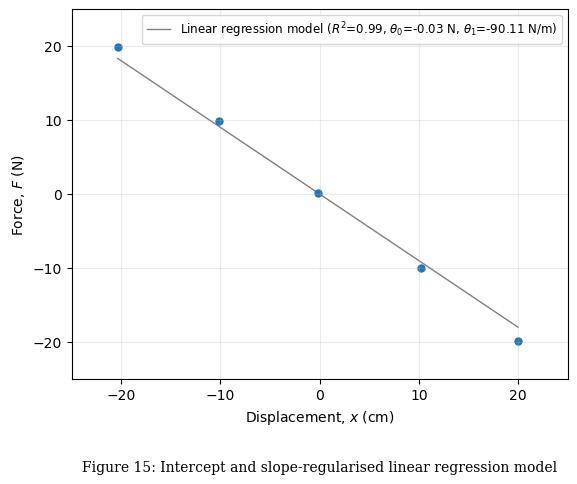

In [17]:
# Set regularisation parameters
alpha=5
mu=0
theta0_prime=0

beta=50
nu=0
theta1_prime=0.8

# Fit and plot linear regression model
theta0, theta1 = fit_lin_regr_params_regul_theta0_theta1(data['x'].values, data['F'].values, alpha, mu, theta0_prime, beta, nu, theta1_prime)
data_model = data.copy(deep=True)
data_model['F'] = theta0 + theta1*data_model['x']

reg_score =  "%.2f" % r2_score(data['F'], data_model['F'])
reg_int = "%.2f" % theta0
reg_slope = "%.2f" % (100*theta1) # convert to N/m
model_label = rf'Linear regression model ($R^2$={reg_score}, $\theta_0$={reg_int} N, $\theta_1$={reg_slope} N/m)'

# Plot
ax = data.plot.scatter(x='x', y='F', s=25)

data_model.plot(x='x', y='F', ax=ax, lw=1, label=model_label, color='grey', zorder=-1)

ax.set_xlabel(f'Displacement, $x$ (cm)')
ax.set_ylabel('Force, $F$ (N)')
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.legend(fontsize=8.5)
plt.grid(alpha=0.25)

caption = "Figure 15: Intercept and slope-regularised linear regression model"
plt.text(.5, -.25, caption, ha='center', font='serif', fontweight='medium', transform=ax.transAxes)
plt.show()

This has worked successfully - the regression model ${\theta}_1$ parameter is approx. 90 N/m, which is roughly midway between our assumed value of 80 N/m, and the intrinsic value of the system which is reflected in the data (100 N/m).

## Conclusion

We have explored some basic techniques which can be used to incorporate physics-based knowledge of a system onto the sorts of regression modelling which is often used in digital twin systems.